In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from functools import partial

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,PolynomialFeatures
from sklearn.impute import SimpleImputer


from sklearn.model_selection import cross_validate,cross_val_score, train_test_split,KFold

from sklearn.metrics import mean_squared_log_error, make_scorer, r2_score, mean_absolute_error, mean_absolute_percentage_error

from lightgbm import LGBMRegressor

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import joblib

import json

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [36]:
'''
Функция для расчета количества и доли пропущенных значений в датасете
'''
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

##################################################################################################################
'''
Создадим пользовательскую функцию агрегации для перцентилей. Она нужна, чтобы
в дальнейшем выявить и потом отбросить явно заниженные стоимости кв.м. в квартирах
'''

#определим собственную функцию (которая представляет собой небольшую обертку для quantile):
def perc_2(x):
    return x.quantile(.02)
def perc_3(x):
    return x.quantile(.03)
def perc_4(x):
    return x.quantile(.04)
def perc_5(x):
    return x.quantile(.05)
def perc_7(x):
    return x.quantile(.07)
def perc_10(x):
    return x.quantile(.10)
def perc_12(x):
    return x.quantile(.12)
def perc_15(x):
    return x.quantile(.15)
def perc_17(x):
    return x.quantile(.17)
def perc_20(x):
    return x.quantile(.20)
def perc_25(x):
    return x.quantile(.25)
def perc_50(x):
    return x.quantile(.50)
def perc_75(x):
    return x.quantile(.75)
def perc_90(x):
    return x.quantile(.90)
def perc_95(x):
    return x.quantile(.95)
def perc_97(x):
    return x.quantile(.97)

##################################################################################################################
'''
Функция для выявления коллинеарных признаков
'''

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Эта часть нужна, чтобы убрать целевую переменную
    #y = x['price_sq_m']
    #x = x.drop(columns = ['price_sq_m'])
    
    # Рассчитаем матрицу корреляций между оставшимимся признаками
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Цикл по матрице корреляций для сравнения значений и выбора столбцов для удаления
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # Если значение корреляции превышает заданный threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Удаление одного столбца из каждой пары столбцов с корреляцией выше заданного уровня
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Эта часть нужна, если в исходных данных была целевая переменная и ее надо вернуть
    #x['price_sq_m'] = y
               
    return x

In [32]:
'''
Загрузка исходных файлов
'''
train = pd.read_csv('train.csv', parse_dates=['timestamp'],index_col='id')
test = pd.read_csv('test.csv', parse_dates=['timestamp'],index_col='id')
fix = pd.read_excel('BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')

'''
Исправление исходных ошибок организаторов
'''
train.update(fix,overwrite=True)
test.update(fix,overwrite=True)
print('Fix in train: ', train.index.intersection(fix.index).shape[0])
print('Fix in test : ', test.index.intersection(fix.index).shape[0])

train = train.reset_index()
test = test.reset_index()
##################################################################################################################

'''
Таблица, в которой каждому округу поставлена в соответствие метка +1 или -1 в зависимости от нахождения внутри или
снаружи МКАД, ТТК, Садового и Бульварного кольца.
Интуиция - 2 км от ТТК снаружи и внутри это разные вещи
'''
corr_dist = pd.read_excel('CORR_DISTANCE.xlsx')

'''
Применение меток +1 и -1 к исходным данным
'''

train=pd.merge(train, corr_dist, how="left", on="sub_area")
test=pd.merge(test, corr_dist, how="left", on="sub_area")

train.mkad_km = train.mkad_km * train.mkad_km_bool
train.ttk_km = train.ttk_km * train.ttk_km_bool
train.sadovoe_km = train.sadovoe_km * train.sadovoe_km_bool
train.bulvar_ring_km = train.bulvar_ring_km * train.bulvar_ring_km_bool

test.mkad_km = test.mkad_km * test.mkad_km_bool
test.ttk_km = test.ttk_km * test.ttk_km_bool
test.sadovoe_km = test.sadovoe_km * test.sadovoe_km_bool
test.bulvar_ring_km = test.bulvar_ring_km * test.bulvar_ring_km_bool

train = train.drop(['mkad_km_bool', 'ttk_km_bool', 'sadovoe_km_bool', 'bulvar_ring_km_bool'], axis=1)
test = test.drop(['mkad_km_bool', 'ttk_km_bool', 'sadovoe_km_bool', 'bulvar_ring_km_bool'], axis=1)

##################################################################################################################

'''
Создание новых полей из поля с датой
'''

# Add year, month, day-of-week
train['year'] = train.timestamp.dt.year
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['year'] = test.timestamp.dt.year
test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

##################################################################################################################
'''
Поля со значениями "да/нет" заменим на 1/0
'''

#train['product_type'] = train['product_type'].replace({'Investment': 0, 'OwnerOccupier': 1})
#test['product_type'] = test['product_type'].replace({'Investment': 0, 'OwnerOccupier': 1})

train['culture_objects_top_25'] = train['culture_objects_top_25'].replace({'no': 0, 'yes': 1})
test['culture_objects_top_25'] = test['culture_objects_top_25'].replace({'no': 0, 'yes': 1})

train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].replace({'no': 0, 'yes': 1})
test['thermal_power_plant_raion'] = test['thermal_power_plant_raion'].replace({'no': 0, 'yes': 1})

train['incineration_raion'] = train['incineration_raion'].replace({'no': 0, 'yes': 1})
test['incineration_raion'] = test['incineration_raion'].replace({'no': 0, 'yes': 1})

train['oil_chemistry_raion'] = train['oil_chemistry_raion'].replace({'no': 0, 'yes': 1})
test['oil_chemistry_raion'] = test['oil_chemistry_raion'].replace({'no': 0, 'yes': 1})

train['radiation_raion'] = train['radiation_raion'].replace({'no': 0, 'yes': 1})
test['radiation_raion'] = test['radiation_raion'].replace({'no': 0, 'yes': 1})

train['railroad_terminal_raion'] = train['railroad_terminal_raion'].replace({'no': 0, 'yes': 1})
test['railroad_terminal_raion'] = test['railroad_terminal_raion'].replace({'no': 0, 'yes': 1})

train['big_market_raion'] = train['big_market_raion'].replace({'no': 0, 'yes': 1})
test['big_market_raion'] = test['big_market_raion'].replace({'no': 0, 'yes': 1})

train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].replace({'no': 0, 'yes': 1})
test['nuclear_reactor_raion'] = test['nuclear_reactor_raion'].replace({'no': 0, 'yes': 1})

train['detention_facility_raion'] = train['detention_facility_raion'].replace({'no': 0, 'yes': 1})
test['detention_facility_raion'] = test['detention_facility_raion'].replace({'no': 0, 'yes': 1})

train['water_1line'] = train['water_1line'].replace({'no': 0, 'yes': 1})
test['water_1line'] = test['water_1line'].replace({'no': 0, 'yes': 1})

train['big_road1_1line'] = train['big_road1_1line'].replace({'no': 0, 'yes': 1})
test['big_road1_1line'] = test['big_road1_1line'].replace({'no': 0, 'yes': 1})

train['railroad_1line'] = train['railroad_1line'].replace({'no': 0, 'yes': 1})
test['railroad_1line'] = test['railroad_1line'].replace({'no': 0, 'yes': 1})


##################################################################################################################
'''
Создание новых полей для временного объединения train и test, а затем разъединения
'''
train['train_test'] = 'train'
test['train_test'] = 'test'

##################################################################################################################
'''
Замена явных ошибок в данных на значение NAN
'''

bad_index = train[train.life_sq < 5].index
#print('train.life_sq < 5',bad_index)
train.loc[bad_index, "life_sq"] = np.NaN

bad_index = test[test.life_sq < 5].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[train.full_sq < 5].index
#print('train.full_sq < 5',bad_index)
train.loc[bad_index, "full_sq"] = np.NaN

bad_index = test[test.full_sq < 5].index
test.loc[bad_index, "full_sq"] = np.NaN

bad_index = train[train.life_sq > train.full_sq].index
#print('train.life_sq > train.full_sq',bad_index)
train.loc[bad_index, "life_sq"] = np.NaN

bad_index = test[test.life_sq > test.full_sq].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[(train.kitch_sq >= train.life_sq) | (train.kitch_sq >= train.full_sq)].index
#print('train.kitch_sq >= train.life_sq | full_sq',bad_index)
train.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq >= test.life_sq) | (test.kitch_sq >= test.full_sq)].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
#print('train.kitch_sq == 0 or 1',bad_index)
train.loc[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
#print('(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)',bad_index)
train.loc[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.loc[bad_index, "full_sq"] = np.NaN

bad_index = train[train.life_sq > 300].index
#print('train.life_sq > 300',bad_index)
train.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

bad_index = train[(train.build_year < 1500) | (train.build_year > 2020)].index
train.loc[bad_index, "build_year"] = np.NaN
bad_index = test[(test.build_year < 1500) | (test.build_year > 2020)].index
test.loc[bad_index, "build_year"] = np.NaN

bad_index = train[(train.num_room == 0) | (train.full_sq / train.num_room < 6)].index
train.loc[bad_index, "num_room"] = np.NaN

bad_index = test[(test.num_room == 0) | (test.full_sq / test.num_room < 6)].index
test.loc[bad_index, "num_room"] = np.NaN

bad_index = train[train.floor == 0].index
#print('train.floor == 0', bad_index)
train.loc[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
#print('train.max_floor == 0',bad_index)
train.loc[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor == 0].index
test.loc[bad_index, "floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.loc[bad_index, "max_floor"] = np.NaN

bad_index = train[train.floor > train.max_floor].index
#print('train.floor > train.max_floor',bad_index)
train.loc[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.loc[bad_index, "max_floor"] = np.NaN

bad_index = train[train.state == 33].index
train.loc[bad_index, "state"] = np.NaN

sub_area_bad_preschool_quota = ['Poselenie Desjonovskoe', 'Poselenie Filimonkovskoe','Poselenie Krasnopahorskoe',
                                'Poselenie Moskovskij', 'Poselenie Novofedorovskoe', 'Poselenie Rogovskoe',
                                'Poselenie Shherbinka', 'Poselenie Sosenskoe', 'Poselenie Vnukovskoe',
                                'Poselenie Voskresenskoe', 'Troickij okrug']
bad_index = train[train.sub_area.isin(sub_area_bad_preschool_quota)].index
#print('bad_preschool_quota',bad_index)
train.loc[bad_index, "preschool_quota"] = np.NaN
train.loc[bad_index, "school_quota"] = np.NaN
bad_index = test[test.sub_area.isin(sub_area_bad_preschool_quota)].index
test.loc[bad_index, "preschool_quota"] = np.NaN
test.loc[bad_index, "school_quota"] = np.NaN



##################################################################################################################


Fix in train:  550
Fix in test :  149


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 0 to 30470
Columns: 296 entries, id to train_test
dtypes: datetime64[ns](1), float64(274), int64(17), object(4)
memory usage: 70.1+ MB


In [37]:
missing_values_table(train)

Your selected dataframe has 296 columns and 30471 rows.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
kitch_sq,15891,52.2
build_year,14510,47.6
hospital_beds_raion,14441,47.4
state,13560,44.5
cafe_avg_price_500,13281,43.6
cafe_sum_500_min_price_avg,13281,43.6
cafe_sum_500_max_price_avg,13281,43.6
max_floor,11069,36.3
num_room,9592,31.5
material,9572,31.4


In [6]:
missing_values_table(test)

Your selected dataframe has 295 columns.
There are 52 columns that have missing values.


,Missing Values,% of Total Values
hospital_beds_raion,3418,44.6
cafe_avg_price_500,3159,41.2
cafe_sum_500_max_price_avg,3159,41.2
cafe_sum_500_min_price_avg,3159,41.2
kitch_sq,2162,28.2
build_year,1607,21.0
preschool_quota,1596,20.8
school_quota,1595,20.8
life_sq,1517,19.8
cafe_avg_price_1000,1222,15.9


In [38]:
'''
Будем искать квартиры в одном и том же доме по округу и точному расстоянию до парка и школы
Сгрупируем квартиры, находящиеся в одном и том же доме.
Это позволит заполнить часть пропусков в характеристиках домов и квартир, такие как
год постройки, макс.этаж, материал, площадь кухни и пр.)
'''

# объединим train и test для поиска квартир в одном доме по всему набору данных
tmp_train_test=pd.concat([train,test],ignore_index=True)

# группировка домов по округу, расстоянию до школы и парка
tmp=tmp_train_test[['sub_area','park_km','school_km',
                    'max_floor','material','build_year','kitch_sq',
                    'cafe_avg_price_500', 'cafe_sum_500_max_price_avg', 'cafe_sum_500_min_price_avg',
                    'cafe_avg_price_1000', 'cafe_sum_1000_max_price_avg','cafe_sum_1000_min_price_avg',
                    'cafe_avg_price_1500','cafe_sum_1500_max_price_avg','cafe_sum_1500_min_price_avg', 
                    'cafe_sum_2000_min_price_avg','cafe_avg_price_2000','cafe_sum_2000_max_price_avg',
                    'cafe_sum_3000_max_price_avg','cafe_avg_price_3000','cafe_sum_3000_min_price_avg',
                    'cafe_sum_5000_max_price_avg','cafe_sum_5000_min_price_avg','cafe_avg_price_5000',
                    'prom_part_5000','ID_railroad_station_walk','railroad_station_walk_min',
                    'railroad_station_walk_km','metro_km_walk','metro_min_walk','green_part_2000'
                    
                   ]]
groups=tmp.groupby(['sub_area','park_km','school_km']).agg({
    'sub_area': 'count', 'max_floor': 'max','material': 'max','build_year': 'max','kitch_sq': 'median',
    'cafe_avg_price_500': 'median', 'cafe_sum_500_max_price_avg': 'median', 'cafe_sum_500_min_price_avg': 'median',
    'cafe_avg_price_1000': 'median', 'cafe_sum_1000_max_price_avg': 'median','cafe_sum_1000_min_price_avg': 'median',
    'cafe_avg_price_1500': 'median','cafe_sum_1500_max_price_avg': 'median','cafe_sum_1500_min_price_avg': 'median', 
    'cafe_sum_2000_min_price_avg': 'median','cafe_avg_price_2000': 'median','cafe_sum_2000_max_price_avg': 'median',
    'cafe_sum_3000_max_price_avg': 'median','cafe_avg_price_3000': 'median','cafe_sum_3000_min_price_avg': 'median',
    'cafe_sum_5000_max_price_avg': 'median','cafe_sum_5000_min_price_avg': 'median','cafe_avg_price_5000': 'median',
    'prom_part_5000': 'median','ID_railroad_station_walk': 'max','railroad_station_walk_min': 'median',
    'railroad_station_walk_km': 'median','metro_km_walk': 'median','metro_min_walk': 'median',
    'green_part_2000': 'median'
    
})

tmp_1 = groups[groups.sub_area>1]   # выбор домов, где больше одной квартиры
tmp_1 = tmp_1.drop(['sub_area'],axis=1)
tmp_1 = tmp_1.reset_index()
#tmp_1.to_excel('tmp_1.xlsx')
tmp_1 = tmp_1.rename(columns = {
    'max_floor':                   'max_floor_new', 
    'material':                    'material_new', 
    'build_year':                  'build_year_new',
    'kitch_sq':                    'kitch_sq_new',
    'cafe_avg_price_500':          'cafe_avg_price_500_new', 
    'cafe_sum_500_max_price_avg':  'cafe_sum_500_max_price_avg_new', 
    'cafe_sum_500_min_price_avg':  'cafe_sum_500_min_price_avg_new',
    'cafe_avg_price_1000':         'cafe_avg_price_1000_new', 
    'cafe_sum_1000_max_price_avg': 'cafe_sum_1000_max_price_avg_new',
    'cafe_sum_1000_min_price_avg': 'cafe_sum_1000_min_price_avg_new',
    'cafe_avg_price_1500':         'cafe_avg_price_1500_new',
    'cafe_sum_1500_max_price_avg': 'cafe_sum_1500_max_price_avg_new',
    'cafe_sum_1500_min_price_avg': 'cafe_sum_1500_min_price_avg_new', 
    'cafe_sum_2000_min_price_avg': 'cafe_sum_2000_min_price_avg_new',
    'cafe_avg_price_2000':         'cafe_avg_price_2000_new',
    'cafe_sum_2000_max_price_avg': 'cafe_sum_2000_max_price_avg_new',
    'cafe_sum_3000_max_price_avg': 'cafe_sum_3000_max_price_avg_new',
    'cafe_avg_price_3000':         'cafe_avg_price_3000_new',
    'cafe_sum_3000_min_price_avg': 'cafe_sum_3000_min_price_avg_new',
    'cafe_sum_5000_max_price_avg': 'cafe_sum_5000_max_price_avg_new',
    'cafe_sum_5000_min_price_avg': 'cafe_sum_5000_min_price_avg_new',
    'cafe_avg_price_5000':         'cafe_avg_price_5000_new',
    'prom_part_5000':              'prom_part_5000_new',
    'ID_railroad_station_walk':    'ID_railroad_station_walk_new',
    'railroad_station_walk_min':   'railroad_station_walk_min_new',
    'railroad_station_walk_km':    'railroad_station_walk_km_new',
    'metro_km_walk':               'metro_km_walk_new',
    'metro_min_walk':              'metro_min_walk_new',
    'green_part_2000':             'green_part_2000_new'
})

# добавление данных в исходный датасет
tmp_2 = pd.merge(tmp_train_test, tmp_1,how='left', on=['sub_area','park_km','school_km'])

# замена пустых значений данными других квартир в этом же доме
tmp_2.max_floor =                   tmp_2.max_floor.fillna(tmp_2.max_floor_new)
tmp_2.material =                    tmp_2.material.fillna(tmp_2.material_new)
tmp_2.build_year =                  tmp_2.build_year.fillna(tmp_2.build_year_new)
tmp_2.kitch_sq =                    tmp_2.kitch_sq.fillna(tmp_2.kitch_sq_new)

tmp_2.cafe_avg_price_500 =          tmp_2.cafe_avg_price_500.fillna(tmp_2.cafe_avg_price_500_new)
tmp_2.cafe_sum_500_max_price_avg =  tmp_2.cafe_sum_500_max_price_avg.fillna(tmp_2.cafe_sum_500_max_price_avg_new)
tmp_2.cafe_sum_500_min_price_avg =  tmp_2.cafe_sum_500_min_price_avg.fillna(tmp_2.cafe_sum_500_min_price_avg_new)
tmp_2.cafe_avg_price_1000 =         tmp_2.cafe_avg_price_1000.fillna(tmp_2.cafe_avg_price_1000_new)
tmp_2.cafe_sum_1000_max_price_avg = tmp_2.cafe_sum_1000_max_price_avg.fillna(tmp_2.cafe_sum_1000_max_price_avg_new)
tmp_2.cafe_sum_1000_min_price_avg = tmp_2.cafe_sum_1000_min_price_avg.fillna(tmp_2.cafe_sum_1000_min_price_avg_new)
tmp_2.cafe_avg_price_1500 =         tmp_2.cafe_avg_price_1500.fillna(tmp_2.cafe_avg_price_1500_new)
tmp_2.cafe_sum_1500_max_price_avg = tmp_2.cafe_sum_1500_max_price_avg.fillna(tmp_2.cafe_sum_1500_max_price_avg_new)
tmp_2.cafe_sum_1500_min_price_avg = tmp_2.cafe_sum_1500_min_price_avg.fillna(tmp_2.cafe_sum_1500_min_price_avg_new)
tmp_2.cafe_sum_2000_min_price_avg = tmp_2.cafe_sum_2000_min_price_avg.fillna(tmp_2.cafe_sum_2000_min_price_avg_new)
tmp_2.cafe_avg_price_2000 =         tmp_2.cafe_avg_price_2000.fillna(tmp_2.cafe_avg_price_2000_new)
tmp_2.cafe_sum_2000_max_price_avg = tmp_2.cafe_sum_2000_max_price_avg.fillna(tmp_2.cafe_sum_2000_max_price_avg_new)
tmp_2.cafe_sum_3000_max_price_avg = tmp_2.cafe_sum_3000_max_price_avg.fillna(tmp_2.cafe_sum_3000_max_price_avg_new)
tmp_2.cafe_avg_price_3000 =         tmp_2.cafe_avg_price_3000.fillna(tmp_2.cafe_avg_price_3000_new)
tmp_2.cafe_sum_3000_min_price_avg = tmp_2.cafe_sum_3000_min_price_avg.fillna(tmp_2.cafe_sum_3000_min_price_avg_new)
tmp_2.cafe_sum_5000_max_price_avg = tmp_2.cafe_sum_5000_max_price_avg.fillna(tmp_2.cafe_sum_5000_max_price_avg_new)
tmp_2.cafe_sum_5000_min_price_avg = tmp_2.cafe_sum_5000_min_price_avg.fillna(tmp_2.cafe_sum_5000_min_price_avg_new)
tmp_2.cafe_avg_price_5000 =         tmp_2.cafe_avg_price_5000.fillna(tmp_2.cafe_avg_price_5000_new)
tmp_2.prom_part_5000 =              tmp_2.prom_part_5000.fillna(tmp_2.prom_part_5000_new)
tmp_2.ID_railroad_station_walk =    tmp_2.ID_railroad_station_walk.fillna(tmp_2.ID_railroad_station_walk_new)
tmp_2.railroad_station_walk_min =   tmp_2.railroad_station_walk_min.fillna(tmp_2.railroad_station_walk_min_new)
tmp_2.railroad_station_walk_km =    tmp_2.railroad_station_walk_km.fillna(tmp_2.railroad_station_walk_km_new)
tmp_2.metro_km_walk =               tmp_2.metro_km_walk.fillna(tmp_2.metro_km_walk_new)
tmp_2.metro_min_walk =              tmp_2.metro_min_walk.fillna(tmp_2.metro_min_walk_new)
tmp_2.green_part_2000 =             tmp_2.green_part_2000.fillna(tmp_2.green_part_2000_new)



# обратное разделение на train и test
train = tmp_2[tmp_2.train_test == 'train']
test = tmp_2[tmp_2.train_test == 'test']

# удаление лишних столбцов
drop_col = [
    'train_test',
    'max_floor_new', 
    'material_new', 
    'build_year_new',
    'kitch_sq_new',

    'cafe_avg_price_500_new', 
    'cafe_sum_500_max_price_avg_new', 
    'cafe_sum_500_min_price_avg_new',
    'cafe_avg_price_1000_new', 
    'cafe_sum_1000_max_price_avg_new',
    'cafe_sum_1000_min_price_avg_new',
    'cafe_avg_price_1500_new',
    'cafe_sum_1500_max_price_avg_new',
    'cafe_sum_1500_min_price_avg_new', 
    'cafe_sum_2000_min_price_avg_new',
    'cafe_avg_price_2000_new',
    'cafe_sum_2000_max_price_avg_new',
    'cafe_sum_3000_max_price_avg_new',
    'cafe_avg_price_3000_new',
    'cafe_sum_3000_min_price_avg_new',
    'cafe_sum_5000_max_price_avg_new',
    'cafe_sum_5000_min_price_avg_new',
    'cafe_avg_price_5000_new',
    'prom_part_5000_new',
    'ID_railroad_station_walk_new',
    'railroad_station_walk_min_new',
    'railroad_station_walk_km_new',
    'metro_km_walk_new',
    'metro_min_walk_new',
    'green_part_2000_new'
]


train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#train.info(verbose=True,show_counts=True)
print('Train:',missing_values_table(train))
print('Test:',missing_values_table(test))

Your selected dataframe has 295 columns and 30471 rows.
There are 52 columns that have missing values.
Train:                                        Missing Values  % of Total Values
hospital_beds_raion                             14441               47.4
state                                           13560               44.5
cafe_avg_price_500                              12135               39.8
cafe_sum_500_max_price_avg                      12135               39.8
cafe_sum_500_min_price_avg                      12135               39.8
num_room                                         9592               31.5
preschool_quota                                  7000               23.0
school_quota                                     6997               23.0
life_sq                                          6853               22.5
cafe_avg_price_1000                              5963               19.6
cafe_sum_1000_max_price_avg                      5963               19.6
cafe_sum_1000_

In [ ]:
'''
Ниже блок из нескольких ячеек для подготовки данных для визуализации в dash
- 1-я таблица нужна, чтобы при выборе муниципального образования пользователю предоставлялся ограниченный список 
   метро для выбора. Т.е. только тех станций, которые в обучайщей выборке оказывались рядом с квартирами из 
   выбранного муниципального образования
- 2-я таблица то же самое, но для ж.д. станций

'''

In [28]:
'''
Справка МО на англ и русском
'''
sprav_mo = pd.read_excel('Spravka_MO_rus_eng.xlsx')
sprav_mo = sprav_mo.set_index('NAME')
sprav_mo.to_csv('sprav_mo.csv')

In [100]:
t1_1 = tmp_train_test[['sub_area', 'ID_metro']].dropna()
t1_1_1 = t1_1.drop_duplicates().sort_values('sub_area').reset_index().drop(['index'],axis = 1)
t1_1_1 = pd.merge(
                   sprav_mo,t1_1_1, 
                   left_on = ['NAME_MO_eng'], 
                   right_on = ['sub_area']
                )[['NAME','ID_metro']]

t1_1_1_prettydict = t1_1_1.groupby(['NAME']).groups

t1_1_1_normdict = {}
for item in t1_1_1_prettydict.items():
    # item — это кортеж (ключ, значение)
    t1_1_1_normdict[item[0]] = item[1].tolist()

In [103]:

    #print(item[0], item[1].tolist())
t1_1_1_normdict

{'"Мосрентген"': [0, 1],
 'Академический': [2, 3, 4, 5],
 'Алексеевский': [6, 7, 8],
 'Алтуфьевский': [9, 10, 11],
 'Арбат': [12, 13, 14, 15, 16, 17],
 'Аэропорт': [18, 19, 20, 21],
 'Бабушкинский': [22, 23],
 'Басманный': [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
 'Беговой': [35, 36, 37, 38],
 'Бескудниковский': [39, 40],
 'Бибирево': [41, 42, 43],
 'Бирюлёво Восточное': [44, 45],
 'Бирюлёво Западное': [46, 47],
 'Богородское': [48, 49, 50, 51],
 'Братеево': [52, 53],
 'Бутырский': [54, 55, 56, 57],
 'Вешняки': [58, 59, 60],
 'Внуково': [61],
 'Внуковское': [62],
 'Войковский': [63, 64, 65],
 'Вороновское': [66, 67],
 'Воскресенское': [68],
 'Восточное Дегунино': [69, 70],
 'Восточное Измайлово': [71, 72],
 'Восточный': [73, 74],
 'Выхино-Жулебино': [75, 76, 77, 78, 79, 80, 81],
 'Гагаринский': [82, 83, 84, 85, 86],
 'Головинский': [87, 88, 89, 90, 91],
 'Гольяново': [92, 93],
 'Даниловский': [94, 95, 96, 97, 98, 99, 100, 101, 102],
 'Десёновское': [103],
 'Дмитровский': [104, 105

In [51]:
t1_2 = tmp_train_test[['sub_area', 'ID_railroad_station_walk']].dropna()
t1_2_2 = t1_2.drop_duplicates().sort_values('sub_area').reset_index().drop(['index'],axis = 1)
t1_2_2 = pd.merge(
                    sprav_mo,t1_2_2, 
                    left_on = ['NAME_MO_eng'], 
                    right_on = ['sub_area']
                 )[['NAME','ID_railroad_station_walk']]

In [104]:
t1_2_2_prettydict = t1_2_2.groupby(['NAME']).groups

t1_2_2_normdict = {}
for item in t1_2_2_prettydict.items():
    # item — это кортеж (ключ, значение)
    t1_2_2_normdict[item[0]] = item[1].tolist()
    #print(item[0], item[1].tolist())
t1_2_2_normdict


{'"Мосрентген"': [0, 1],
 'Академический': [2],
 'Алексеевский': [3, 4, 5],
 'Алтуфьевский': [6, 7],
 'Арбат': [8, 9],
 'Аэропорт': [10, 11, 12],
 'Бабушкинский': [13, 14],
 'Басманный': [15, 16, 17, 18, 19],
 'Беговой': [20, 21],
 'Бескудниковский': [22, 23, 24, 25],
 'Бибирево': [26, 27, 28],
 'Бирюлёво Восточное': [29, 30, 31],
 'Бирюлёво Западное': [32, 33],
 'Богородское': [34, 35, 36],
 'Братеево': [37, 38],
 'Бутырский': [39, 40, 41, 42, 43],
 'Вешняки': [44, 45, 46, 47, 48],
 'Внуково': [49, 50, 51],
 'Внуковское': [52, 53, 54, 55, 56],
 'Войковский': [57, 58, 59],
 'Вороновское': [60, 61, 62],
 'Воскресенское': [63, 64],
 'Восточное Дегунино': [65, 66, 67, 68],
 'Восточное Измайлово': [69, 70],
 'Восточный': [71, 72, 73],
 'Выхино-Жулебино': [74, 75, 76],
 'Гагаринский': [77],
 'Головинский': [78, 79, 80, 81, 82],
 'Гольяново': [83],
 'Даниловский': [84, 85, 86, 87, 88],
 'Десёновское': [89, 90, 91],
 'Дмитровский': [92, 93, 94],
 'Донской': [95, 96, 97],
 'Дорогомилово': [98,

In [105]:
# Serialize data into file:

json.dump(t1_1_1_normdict, open( "spravka_mo_sub_area_ID_metro.json", 'w' ) )
json.dump(t1_2_2_normdict, open( "spravka_mo_sub_area_ID_railroad_station_walk.json", 'w' ) )

# Read data from file:
#data = json.load( open( "file_name.json" ) )

In [146]:
agg_func_bul = {
    'bulvar_ring_km': ['min','max']
}

agg_func_ttk = {
    'ttk_km': ['min','max']
}

agg_func_mkad = {
    'mkad_km': ['min','max']
}

agg_func_metro_min = {
    'metro_min_walk': ['min','max']
}

In [114]:
t_bul = tmp_train_test[['sub_area', 'bulvar_ring_km']].dropna()
t_bul

,sub_area,bulvar_ring_km
0,Bibirevo,-13.675657
1,Nagatinskij Zaton,-8.132640
2,Tekstil'shhiki,-8.054252
3,Mitino,-18.309433
4,Basmannoe,0.787593
...,...,...
38128,Kon'kovo,-12.086185
38129,Poselenie Desjonovskoe,-28.385104
38130,Staroe Krjukovo,-35.265782
38131,Orehovo-Borisovo Juzhnoe,-16.528376


In [118]:
t_bul_agg = t_bul.groupby(['sub_area']).agg(agg_func_bul).round(3)
#t_bul_agg.to_excel('bulvar_ring_km.xlsx')

In [124]:
sprav_bul = pd.read_excel('bulvar_ring_km.xlsx')
sprav_bul = pd.merge(
                   sprav_mo,sprav_bul, 
                   left_on = ['NAME_MO_eng'], 
                   right_on = ['sub_area']
                )[['NAME','min','max']]
sprav_bul = sprav_bul.set_index('NAME')
sprav_bul

,min,max
NAME,,
"""Мосрентген""",-17.9,-14.8
Академический,-8.9,-3.7
Алексеевский,-7.7,-3.1
Алтуфьевский,-14.2,-10.9
Арбат,-2.1,1.1
Аэропорт,-8.6,-2.5
Бабушкинский,-14.1,-9.0
Басманный,-4.9,2.1
Беговой,-5.0,-1.1


In [126]:
#sprav_bul.to_csv('bulvar_ring_km.csv')

In [135]:
t_ttk = tmp_train_test[['sub_area', 'ttk_km']].dropna()
t_mkad = tmp_train_test[['sub_area', 'mkad_km']].dropna()

In [138]:
t_ttk_agg = t_ttk.groupby(['sub_area']).agg(agg_func_ttk).round(3)
t_mkad_agg = t_mkad.groupby(['sub_area']).agg(agg_func_mkad).round(3)

#t_ttk_agg.to_excel('ttk_km.xlsx')
#t_mkad_agg.to_excel('mkad_km.xlsx')

In [142]:
sprav_ttk = pd.read_excel('ttk_km.xlsx')
sprav_ttk = pd.merge(
                   sprav_mo,sprav_ttk, 
                   left_on = ['NAME_MO_eng'], 
                   right_on = ['sub_area']
                )[['NAME','min','max']]
sprav_ttk = sprav_ttk.set_index('NAME')

sprav_mkad = pd.read_excel('mkad_km.xlsx')
sprav_mkad = pd.merge(
                   sprav_mo,sprav_mkad, 
                   left_on = ['NAME_MO_eng'], 
                   right_on = ['sub_area']
                )[['NAME','min','max']]
sprav_mkad = sprav_mkad.set_index('NAME')

In [143]:
sprav_ttk.to_csv('ttk_km.csv')
sprav_mkad.to_csv('mkad_km.csv')

In [141]:
sprav_ttk

,NAME,min,max
0,"""Мосрентген""",-13.9,-10.8
1,Академический,-4.6,0.4
2,Алексеевский,-4.6,-0.2
3,Алтуфьевский,-11.4,-8.1
4,Арбат,2.2,4.3
5,Аэропорт,-5.2,0.9
6,Бабушкинский,-10.9,-5.9
7,Басманный,-2.1,3.9
8,Беговой,-1.1,1.9
9,Бескудниковский,-10.7,-6.1


In [144]:
t_metro_min = tmp_train_test[['sub_area', 'metro_min_walk']].dropna()

In [148]:
t_metro_min_agg = t_metro_min.groupby(['sub_area']).agg(agg_func_metro_min).round(0)
t_metro_min_agg

metro_min_walk       
                                          min    max
sub_area                                            
Ajeroport                                 2.0   24.0
Akademicheskoe                            2.0   24.0
Alekseevskoe                              1.0   26.0
Altuf'evskoe                              4.0   44.0
Arbat                                     3.0   16.0
Babushkinskoe                             2.0   25.0
Basmannoe                                 1.0   17.0
Begovoe                                   7.0   31.0
Beskudnikovskoe                           2.0   25.0
Bibirevo                                  2.0   34.0
Birjulevo Vostochnoe                     23.0   84.0
Birjulevo Zapadnoe                       54.0   80.0
Bogorodskoe                               1.0   35.0
Brateevo                                  1.0   28.0
Butyrskoe                                 1.0   22.0
Caricyno                                  2.0   37.0
Cheremushki                               2.0   32.0
Chertanovo Central'noe                    1.0   31.0
Chertanovo Juzhnoe                        0.0   26.0
Chertanovo Severnoe                       0.0   27.0
Danilovskoe                               0.0   44.0
Dmitrovskoe                              20.0   55.0
Donskoe                                   1.0   19.0
Dorogomilovo                              2.0   19.0
Filevskij Park                            2.0   55.0
Fili Davydkovo                            2.0   51.0
Gagarinskoe                               1.0   39.0
Gol'janovo                                2.0   46.0
Golovinskoe                               1.0   40.0
Hamovniki                                 1.0   19.0
Horoshevo-Mnevniki                        1.0   52.0
Horoshevskoe                              1.0   29.0
Hovrino                                   5.0   34.0
Ivanovskoe                                7.0   52.0
Izmajlovo                                 1.0   28.0
Jakimanka                                 2.0   17.0
Jaroslavskoe                             30.0   85.0
Jasenevo                                  1.0   36.0
Juzhnoe Butovo                            1.0  106.0
Juzhnoe Medvedkovo                       12.0   43.0
Juzhnoe Tushino                           2.0   44.0
Juzhnoportovoe                            3.0   18.0
Kapotnja                                 37.0  101.0
Kon'kovo                                  2.0   29.0
Koptevo                                   1.0   32.0
Kosino-Uhtomskoe                          4.0   38.0
Kotlovka                                  9.0   26.0
Krasnosel'skoe                            2.0   15.0
Krjukovo                                219.0  281.0
Krylatskoe                                2.0   60.0
Kuncevo                                   3.0   67.0
Kurkino                                  46.0   86.0
Kuz'minki                                 2.0   28.0
Lefortovo                                 1.0   23.0
Levoberezhnoe                             2.0   29.0
Lianozovo                                 2.0   39.0
Ljublino                                  0.0   55.0
Lomonosovskoe                             8.0   27.0
Losinoostrovskoe                         12.0   49.0
Mar'ina Roshha                            1.0   19.0
Mar'ino                                   3.0   36.0
Marfino                                   7.0   29.0
Matushkino                              276.0  302.0
Meshhanskoe                               1.0   16.0
Metrogorodok                             10.0   35.0
Mitino                                    0.0   35.0
Molzhaninovskoe                         163.0  163.0
Moskvorech'e-Saburovo                     7.0   52.0
Mozhajskoe                               24.0   91.0
Nagatino-Sadovniki                        0.0   29.0
Nagatinskij Zaton                         3.0   43.0
Nagornoe                                  0.0   19.0
Nekrasovka                                1.0   51.0
Niz

In [155]:
#t_metro_min_agg.columns=t_metro_min_agg.columns.droplevel(0)
#t_metro_min_agg

In [157]:
t_metro_min_agg['min'] = t_metro_min_agg['min'] - 10
t_metro_min_agg['max'] = t_metro_min_agg['max'] + 10
t_metro_min_agg

,min,max
sub_area,,
Ajeroport,-8.0,34.0
Akademicheskoe,-8.0,34.0
Alekseevskoe,-9.0,36.0
Altuf'evskoe,-6.0,54.0
Arbat,-7.0,26.0
Babushkinskoe,-8.0,35.0
Basmannoe,-9.0,27.0
Begovoe,-3.0,41.0
Beskudnikovskoe,-8.0,35.0


In [159]:
t_metro_min_agg.loc[(t_metro_min_agg['min'] < 0),'min'] = 0

In [160]:
t_metro_min_agg

,min,max
sub_area,,
Ajeroport,0.0,34.0
Akademicheskoe,0.0,34.0
Alekseevskoe,0.0,36.0
Altuf'evskoe,0.0,54.0
Arbat,0.0,26.0
Babushkinskoe,0.0,35.0
Basmannoe,0.0,27.0
Begovoe,0.0,41.0
Beskudnikovskoe,0.0,35.0


In [162]:
sprav_metro_min_walk = pd.merge(
                   sprav_mo,t_metro_min_agg, 
                   left_on = ['NAME_MO_eng'], 
                   right_on = ['sub_area']
                )[['NAME','min','max']]
sprav_metro_min_walk = sprav_metro_min_walk.set_index('NAME')


sprav_metro_min_walk.to_csv('metro_min_walk.csv')

In [39]:
'''
Отсутствующие значения общей площади заменим медианными значениями
'''

#train=train[train['full_sq'].notna()]
train['full_sq'].fillna(train['full_sq'].median(),inplace=True)
test['full_sq'].fillna(train['full_sq'].median(),inplace=True)

##################################################################################################################

'''
Скорректируем данные в столбце, похожем на деление Новостройка / вторичка.
Разделим данные относительно года постройки, равному 2011
'''
'''
train['prod_type_new'] = np.where(train['build_year'] > 2011, 'OwnerOccupier', train['product_type'])
train['product_type'] = np.where(train['build_year'] <= 2011, 'Investment', train['prod_type_new'])
train = train.drop(['prod_type_new'], axis=1)

test['prod_type_new'] = np.where(test['build_year'] > 2011, 'OwnerOccupier', test['product_type'])
test['product_type'] = np.where(test['build_year'] <= 2011, 'Investment', test['prod_type_new'])
test = test.drop(['prod_type_new'], axis=1)
'''
'''
test['prod_type_new'] = np.where(test['build_year'] >= 2011, 'OwnerOccupier', 'Investment')
test['product_type'] = test['product_type'].fillna(test['prod_type_new'])
test = test.drop(['prod_type_new'], axis=1)
'''

##################################################################################################################

'''
Добавим столбец со стоимостью кв.м. с идей использовать его как целевой вместо общей стоимости квартиры
'''

train['price_sq_m']=(train['price_doc']/train.full_sq)/1000

In [89]:
#test['prod_type_new'] = np.where(test['build_year'] >= 2011, 'OwnerOccupier', 'Investment')
#test['product_type'] = test['product_type'].fillna(test['prod_type_new'])
#test[['id','build_year','prod_type_new','product_type']].to_excel('tmp_1_3.xlsx')

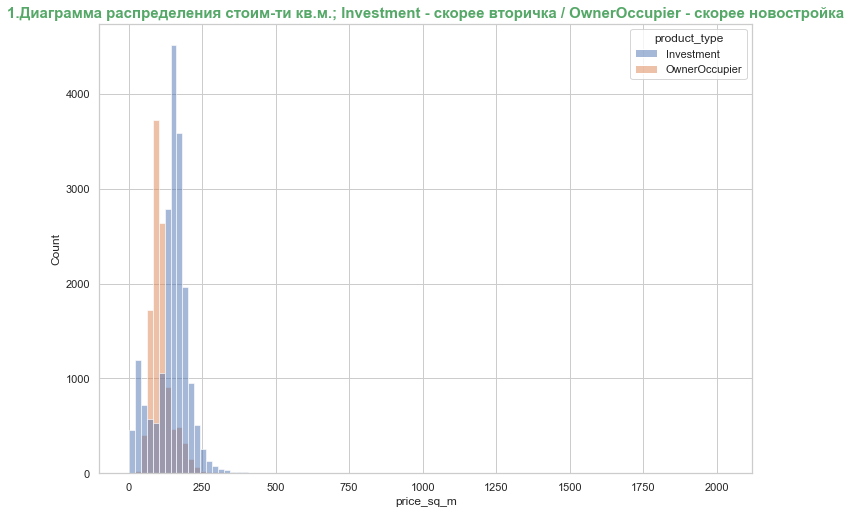

In [40]:
sns.set(style='whitegrid', color_codes=True,rc={'figure.figsize':(11.7,8.27)})

sns.histplot(
    data=train,
    x='price_sq_m',
    bins=100,
    hue=train.product_type,
)
plt.title('1.Диаграмма распределения стоим-ти кв.м.; Investment - скорее вторичка / OwnerOccupier - скорее новостройка', 
          size=15, color='g', weight='bold')
plt.show();

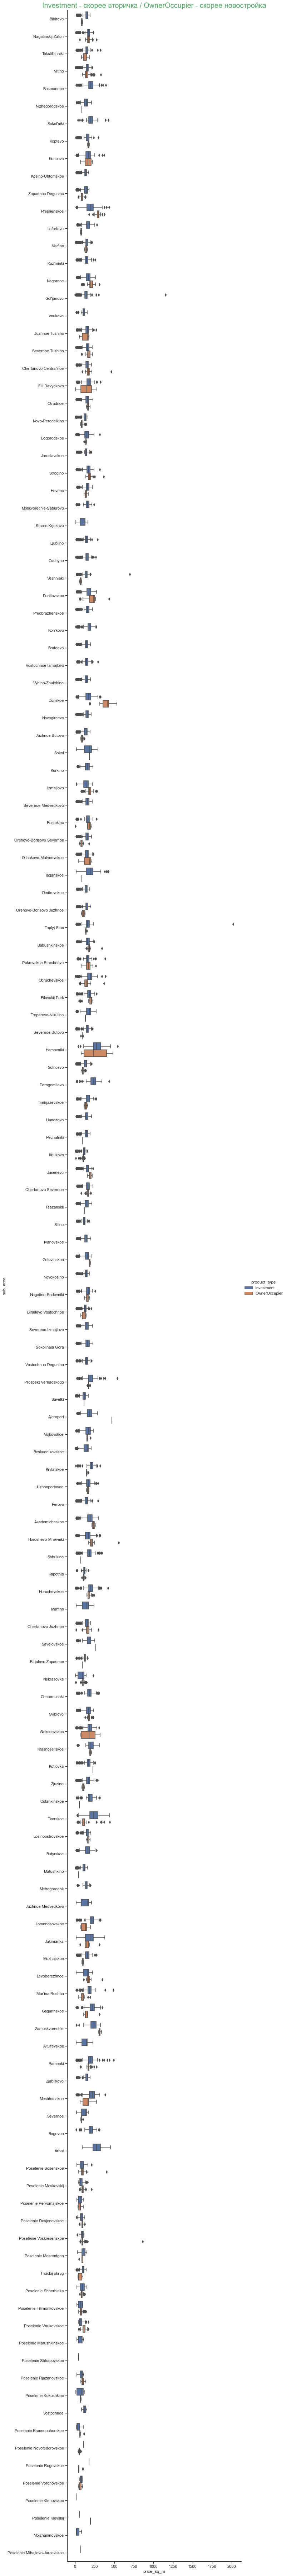

In [13]:
'''
Посмотрим зависимость стоимости кв.м в разных округах
'''

sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=train, 
    hue='product_type',    # оба на одном графике разными цветами
    height=100, 
    aspect=0.1, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

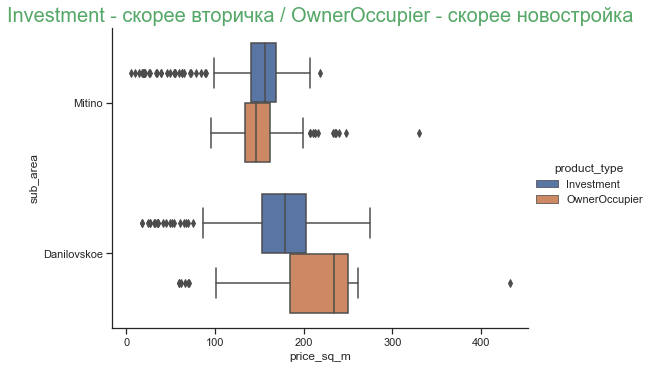

In [53]:
'''
Посмотрим зависимость стоимости кв.м в разных округах
'''

sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=train[(train.sub_area == 'Mitino') | (train.sub_area == 'Danilovskoe')], 
    hue='product_type',    # оба на одном графике разными цветами
    #height=10, 
    aspect=1.5, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

In [54]:
'''
В данных большое количество нереально низких стоимостей квадратного метра и некоторое количество очень больших.
Вероятно, присутствуют как ошибки, так и сознательное занижение стоимости, например, для ухода от налогов.
Исключим из данных заниженные и завышенные стоимости

Агрегация по округу и типу квартиры (новостройка/вторичка) для выбора границы заниженных цен
{'Investment': 0, 'OwnerOccupier': 1}
0 - вторичка
1 - новостройка
'''

agg_func = {
    'price_sq_m': ['count','std','min','max',perc_2, perc_3, perc_4, perc_5,perc_7,
                   perc_10,perc_12,perc_15,perc_17,perc_20,
                   perc_25,perc_50,perc_75,perc_90,perc_95, perc_97]
}

df=train.groupby(['sub_area','product_type']).agg(agg_func).round(1)
df.columns=df.columns.droplevel(0)

'''
После агрегации выбрал перцентили в качестве границы для отсечения слишком дешевых стоимостей по округам
'''
#df.xs('Investment', level=1).sort_values('count',ascending=False)
#df.xs('OwnerOccupier', level=1).sort_values('count',ascending=False)

train_temp=pd.merge(train,df[['perc_7','perc_25', 'perc_95']], how="left", on=["sub_area","product_type"])
#,'perc_10'

'''
Исключаем строки со стоимостью кв.м. ниже 4-го перцентиля во вторичке и ниже 3-го перцентиля в новостройках
по каждому из округов
'''
train=train_temp[((train_temp.product_type=='OwnerOccupier') & (train_temp.price_sq_m>=train_temp.perc_7)) | 
                      ((train_temp.product_type=='Investment') & (train_temp.price_sq_m>=train_temp.perc_25))]

'''
Исключаем строки с экстремально высокими значениями стоимости квадратного метра, 
выше 90 перцентиля по каждому из округов
'''
#train = train[train.price_sq_m <= 600]

train=train[train.price_sq_m <= train.perc_95]



'''
Удалим столбцы, которые не понадобятся
'''
train_drop_col=['timestamp','price_doc', 'perc_7', 'perc_25','perc_95','id']
#,'perc_10'
test_drop_col=['timestamp']

train = train.drop(columns = train_drop_col)
test = test.drop(columns = test_drop_col)


##################################################################################################################
'''
Присвоим столбцам, где по смыслу катеориальные признаки, тип данных "category"
'''
categ_col = [
    'year', 'month', 'dow', 'product_type', 'sub_area', 'ecology', 'state','material', 'ID_metro',
    'ID_railroad_station_walk', 'ID_railroad_station_avto', 'ID_big_road1','ID_big_road2', 'ID_railroad_terminal', 
    'ID_bus_terminal', 
    #'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion',
    #'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion',
    #'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line'
]

for c in categ_col:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [239]:
df.xs('Investment', level=1).sort_values('count',ascending=False)

,count,std,min,max,perc_2,perc_3,perc_4,perc_5,perc_7,perc_10,perc_12,perc_15,perc_17,perc_20,perc_25,perc_50,perc_75,perc_90,perc_95,perc_97
sub_area,,,,,,,,,,,,,,,,,,,,
Mar'ino,506,41.5,6.3,213.2,19.1,25.4,26.5,30.4,37.3,58.8,99.0,124.3,128.2,131.7,137.9,151.5,163.8,174.9,180.9,184.2
Juzhnoe Butovo,422,41.1,11.6,193.8,20.9,23.3,24.1,26.3,30.2,51.4,59.1,94.4,104.6,113.6,120.6,141.1,155.3,164.5,171.4,173.7
Otradnoe,351,49.1,12.7,230.5,15.9,18.9,25.4,26.9,38.1,50.0,60.3,95.3,100.4,122.1,136.0,160.0,175.0,187.0,193.0,198.7
Ljublino,296,43.1,12.0,288.9,21.5,24.1,26.2,29.1,36.7,48.8,67.5,116.3,123.0,128.6,132.9,146.9,160.0,172.3,178.6,183.0
Gol'janovo,294,75.8,1.4,1154.0,22.5,23.9,25.4,26.2,27.4,37.7,49.7,66.7,92.6,119.9,124.4,140.3,154.5,168.7,181.8,191.6
Krjukovo,277,35.6,5.3,155.6,13.7,14.7,19.2,19.6,24.4,27.1,33.9,73.6,89.4,100.2,108.3,117.0,126.2,133.3,138.5,141.7
Bogorodskoe,272,51.8,10.8,314.1,22.1,22.4,25.8,27.3,32.2,44.3,51.2,88.7,100.4,122.3,130.0,155.6,174.6,193.6,202.4,209.9
Vyhino-Zhulebino,264,41.9,9.8,196.7,21.9,22.6,25.6,27.9,37.0,48.7,67.5,114.5,119.9,125.7,129.1,146.9,159.1,167.7,173.1,178.3
Mitino,254,40.3,5.4,218.4,19.6,23.6,33.5,39.0,61.2,92.8,117.2,129.0,134.1,137.6,142.7,156.9,169.7,182.0,186.7,190.4


In [240]:
df.xs('OwnerOccupier', level=1).sort_values('count',ascending=False)

,count,std,min,max,perc_2,perc_3,perc_4,perc_5,perc_7,perc_10,perc_12,perc_15,perc_17,perc_20,perc_25,perc_50,perc_75,perc_90,perc_95,perc_97
sub_area,,,,,,,,,,,,,,,,,,,,
Poselenie Sosenskoe,1770,18.1,37.3,399.8,70.1,73.5,74.8,75.6,76.3,77.0,77.2,77.8,78.0,79.0,80.6,91.2,106.2,117.4,124.8,128.6
Nekrasovka,1668,12.7,9.8,232.9,77.7,80.7,81.6,81.7,84.2,87.5,88.5,90.0,91.3,92.2,93.7,101.8,106.5,113.9,121.5,124.2
Poselenie Vnukovskoe,1397,19.3,44.9,166.7,72.7,75.1,75.8,76.7,79.2,83.3,85.6,88.5,90.3,93.7,97.4,114.0,125.9,133.2,140.7,144.0
Poselenie Moskovskij,899,15.0,40.9,210.8,72.5,74.4,75.5,76.1,77.5,79.8,80.9,82.4,83.2,84.4,85.9,94.8,105.4,118.4,124.2,127.4
Poselenie Voskresenskoe,740,30.8,26.9,862.8,77.2,78.4,79.9,80.3,80.8,81.8,82.9,83.8,84.7,85.7,86.9,93.6,101.9,111.2,115.8,125.5
Poselenie Filimonkovskoe,547,14.3,47.3,137.8,52.2,54.1,54.7,55.5,57.7,58.4,59.3,60.8,61.3,62.2,65.2,73.5,80.4,90.6,101.5,109.4
Poselenie Shherbinka,430,10.9,58.8,123.4,66.5,68.5,69.4,70.3,71.5,72.5,73.4,74.5,75.3,76.3,77.5,82.5,89.6,99.7,106.3,108.9
Mitino,426,25.9,17.1,329.8,112.2,116.7,118.5,120.1,122.2,124.3,126.2,128.5,129.6,131.2,133.3,145.9,162.0,173.4,188.5,201.3
Poselenie Desjonovskoe,396,12.0,55.6,125.5,67.9,71.1,74.7,75.5,76.6,78.1,79.6,80.2,81.2,82.4,84.4,90.9,100.4,109.2,112.9,113.7


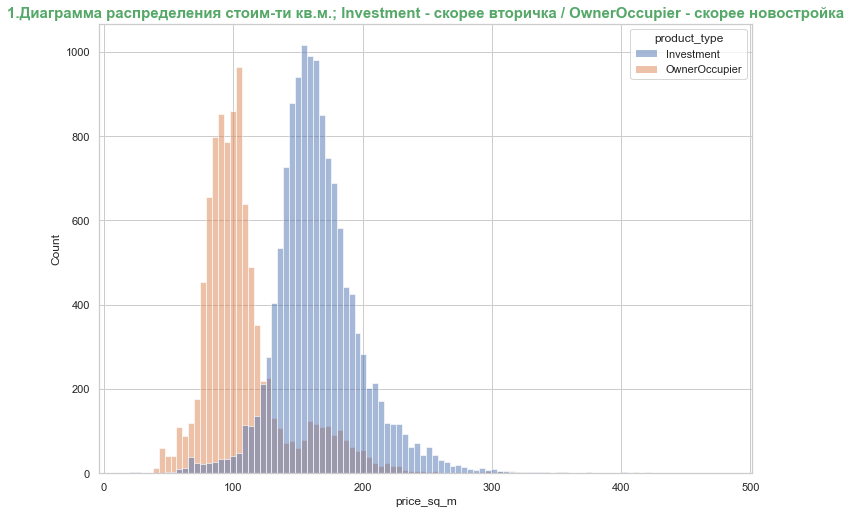

In [55]:
'''
Обновленная диаграмма после очистки стоимостей
'''

sns.set(style='whitegrid', color_codes=True,rc={'figure.figsize':(11.7,8.27)})

sns.histplot(
    data = train,
    x = 'price_sq_m',
    bins = 100,
    hue = train.product_type,
)
plt.title('1.Диаграмма распределения стоим-ти кв.м.; Investment - скорее вторичка / OwnerOccupier - скорее новостройка', 
          size=15, color='g', weight='bold')
plt.show();

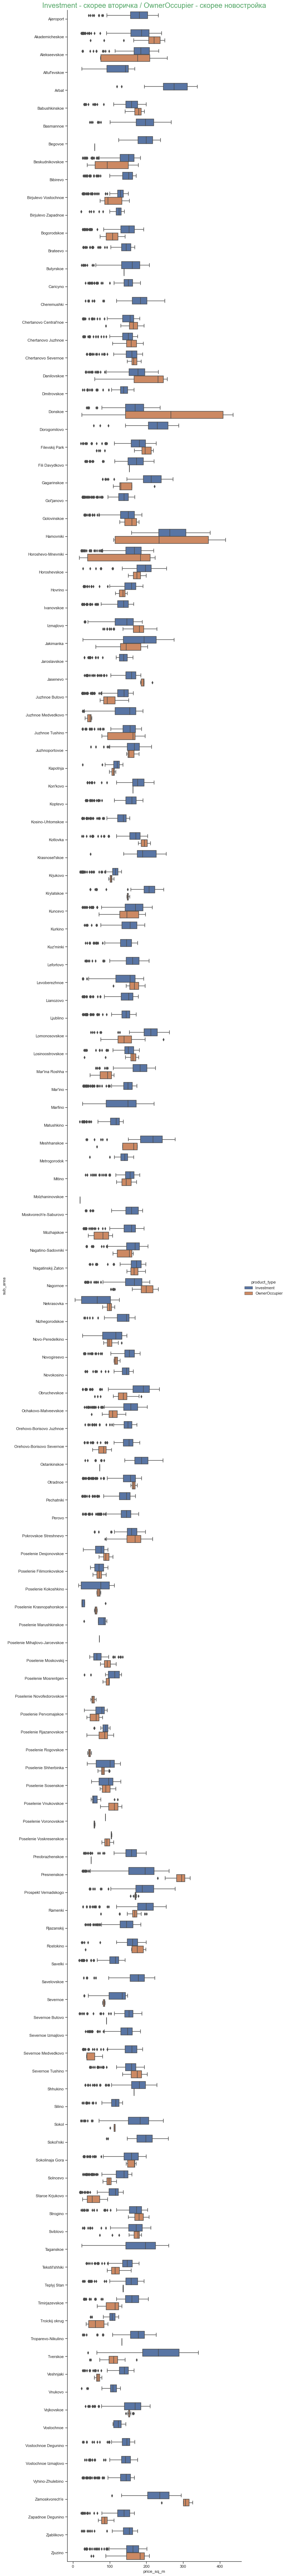

In [272]:
'''
Обновленная диаграмма зависимости стоимости кв.м в разных округах.
Очевидно, что осталось много заниженных стоимостей. Это видно на обоих графиках. На графике выше это синий горб в
левой части, на графике ниже это точки левее 25-го перцентиля.
В этой версии модели я их выбрасывать из данных для обучения не стал, т.к. опытным путем определил, что в тестовых
данных Kaggle заниженные стоимости также оставлены. С этими заниженными стоимостями результат на Kaggle получается 
значительно лучше.
Но если использовать модель для реальной жизни, например, проверки заявленной стоимости квартиры в заявках на ипотеку,
то эти заниженные стоимости надо вычищать.
'''

sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=train, 
    hue='product_type',    # оба на одном графике разными цветами
    height=100, 
    aspect=0.1, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

In [72]:
a = train
a['sub_area'] = a['sub_area'].astype('object')
a=a[(a.sub_area == 'Mitino') | (a.sub_area == 'Danilovskoe')]

In [66]:
a['sub_area'].astype('object')

3             Mitino
220      Danilovskoe
224      Danilovskoe
356      Danilovskoe
358           Mitino
773           Mitino
804           Mitino
820      Danilovskoe
827      Danilovskoe
866           Mitino
1047     Danilovskoe
1104          Mitino
1122          Mitino
1137          Mitino
1273     Danilovskoe
1334     Danilovskoe
1418          Mitino
1444     Danilovskoe
1566          Mitino
1773          Mitino
1993          Mitino
2126          Mitino
2171          Mitino
2175          Mitino
2177     Danilovskoe
2207          Mitino
2238          Mitino
2350     Danilovskoe
2406     Danilovskoe
2483          Mitino
2530     Danilovskoe
2622     Danilovskoe
2655          Mitino
2666          Mitino
2719          Mitino
2785          Mitino
3071     Danilovskoe
3088     Danilovskoe
3091          Mitino
3334          Mitino
3368          Mitino
3411          Mitino
3481          Mitino
3482          Mitino
3483          Mitino
3502          Mitino
3518          Mitino
3525         

In [73]:
a['sub_area'].unique()

array(['Mitino', 'Danilovskoe'], dtype=object)

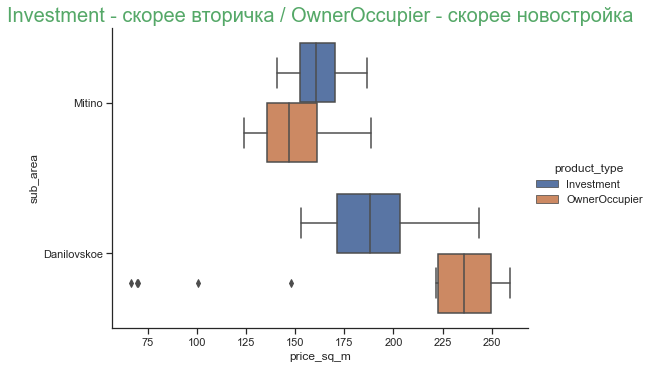

In [75]:
sns.set(style="ticks", color_codes=True)

sns.catplot(
    x='price_sq_m',
    y='sub_area', 
    data=a, 
    hue='product_type',    # оба на одном графике разными цветами
    #height=10, 
    aspect=1.5, 
    kind='box', 
    dodge=True) 
# Можно использовать dodge=True чтобы не накладывать показатели друг на друга, а выстроить рядом друг с другом
plt.title('Investment - скорее вторичка / OwnerOccupier - скорее новостройка', size=20, color='g');

In [76]:
missing_values_table(train)

Your selected dataframe has 293 columns and 23134 rows.
There are 51 columns that have missing values.


,Missing Values,% of Total Values
hospital_beds_raion,11342,49.0
state,10336,44.7
cafe_sum_500_min_price_avg,9571,41.4
cafe_sum_500_max_price_avg,9571,41.4
cafe_avg_price_500,9571,41.4
num_room,6970,30.1
preschool_quota,6033,26.1
school_quota,6032,26.1
life_sq,5974,25.8
cafe_sum_1000_min_price_avg,4991,21.6


In [ ]:
'''
С учетом графика выше, видимо, надо делать разные модели для новостроек и вторички
'''
# описательная статитика по числовым полям
# train.describe().to_excel('train_describe.xlsx')

In [309]:
#train.info(verbose=True,show_counts=True)

In [ ]:
'''
Далее решению задачи по сокращению количества признаков при несущественном снижении качества 
'''

In [90]:
'''
В качестве точки осчета или "эталонного" результата возьмем модель с лучшим результатом на kaggle и 
рассчитаем метрики качесва на тестовых данных.
Результаты после исключения признаков будем сравнивать с этими метриками
'''
train_temp_1 = train

# делим обучающую выборку на две части по полю product_type
train_temp_1_Invest = train_temp_1[train_temp_1.product_type=='Investment']
train_temp_1_OwOc = train_temp_1[train_temp_1.product_type=='OwnerOccupier']

# train, test
y_train_1_Invest = train_temp_1_Invest['price_sq_m']
X_train_1_Invest = train_temp_1_Invest.drop(columns = ['price_sq_m','product_type'])
print(f"Investment shape: {X_train_1_Invest.shape},{y_train_1_Invest.shape}")

y_train_1_OwOc = train_temp_1_OwOc['price_sq_m']
X_train_1_OwOc = train_temp_1_OwOc.drop(columns = ['price_sq_m','product_type'])
print(f"OwnerOccupier shape: {X_train_1_OwOc.shape},{y_train_1_OwOc.shape}")


kfold = KFold(n_splits=6, shuffle=True, random_state=42)

score_1 = make_scorer(mean_absolute_error)
score_2 = make_scorer(r2_score)
score_3 = make_scorer(mean_squared_log_error, squared=False)


reg_lgbm_Invest = LGBMRegressor()

reg_lgbm_OwOc = LGBMRegressor()


n=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_1)
print(f"\nInvestment mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_3)
print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")

n=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_1)
print(f"\nOwnerOccupier mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_3)
print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")


Investment shape: (13526, 291),(13526,)
OwnerOccupier shape: (9608, 291),(9608,)

Investment mean_absolute: 10.5720
folds mean_absolute: [10.87848302 10.64936736 10.8264167  10.18811864 10.33909333 10.55041607]

Investment mean_log_error: 0.0884
folds mean_log_error: [0.09141039 0.09063631 0.08574814 0.08447952 0.08683673 0.09129803]

OwnerOccupier mean_absolute: 5.1556
folds mean_absolute: [5.28730729 4.95245218 5.33255417 5.06723767 5.29906233 4.99489938]

OwnerOccupier mean_log_error: 0.0711
folds mean_log_error: [0.07420776 0.06350716 0.07438847 0.07188379 0.07467987 0.068101  ]


In [ ]:
Investment shape: (13170, 291),(13170,)
OwnerOccupier shape: (9680, 291),(9680,)

Investment mean_absolute: 10.3896
folds mean_absolute: [10.65164481 10.53136592 10.4125791  10.16154625 10.21150584 10.36924358]

Investment mean_log_error: 0.0874
folds mean_log_error: [0.09622416 0.08947485 0.08995157 0.08000544 0.08200434 0.08678183]

OwnerOccupier mean_absolute: 5.9797
folds mean_absolute: [6.10838599 5.72251896 6.41145757 6.21587216 5.77831442 5.64189655]

OwnerOccupier mean_log_error: 0.0949
folds mean_log_error: [0.096441   0.09127408 0.10066515 0.11235536 0.08623836 0.08268748]

In [98]:
'''
Таблица значимости признаков для 1-й части модели
'''

reg_lgbm_Invest.fit(X_train_1_Invest, y_train_1_Invest)
df_import_Invest = pd.DataFrame({
                                 'feature_Invest': reg_lgbm_Invest.feature_name_,
                                 'importance_Invest': reg_lgbm_Invest.feature_importances_}
                                ).sort_values(by='importance_Invest',ascending=False).reset_index()
df_import_Invest

,index,feature_Invest,importance_Invest
0,9,sub_area,364
1,81,ID_metro,225
2,0,full_sq,187
3,5,build_year,164
4,1,life_sq,133
5,2,floor,107
6,3,max_floor,98
7,288,year,97
8,289,month,83
9,99,ID_railroad_station_avto,77


In [97]:
'''
Таблица значимости признаков для 2-й части модели
'''

reg_lgbm_OwOc.fit(X_train_1_OwOc, y_train_1_OwOc)
df_import_OwOc = pd.DataFrame({
                               'feature_OwOc': reg_lgbm_OwOc.feature_name_, 
                               'importance_OwOc': reg_lgbm_OwOc.feature_importances_}
                             ).sort_values(by='importance_OwOc',ascending=False).reset_index()
df_import_OwOc

,index,feature_OwOc,importance_OwOc
0,0,full_sq,377
1,2,floor,157
2,288,year,151
3,289,month,150
4,9,sub_area,113
5,1,life_sq,99
6,3,max_floor,83
7,6,num_room,81
8,81,ID_metro,56
9,116,zd_vokzaly_avto_km,48


In [71]:
#поиск наименее коррелирующих признаков с ценой (целевой переvенной)
corrs_find = train_temp_1_Invest.corr(method='pearson')
#corrs_find.to_excel('train_corrs.xlsx')
corrs_find_prices = corrs_find["price_sq_m"]
corrs_find_prices.sort_values()

#corrs_find_prices[abs(corrs_find_prices).argsort()[::-1]].tail(200).sort_values()

kremlin_km                              -0.605530
zd_vokzaly_avto_km                      -0.597205
stadium_km                              -0.458371
nuclear_reactor_km                      -0.452624
mosque_km                               -0.445073
basketball_km                           -0.426895
exhibition_km                           -0.397561
thermal_power_plant_km                  -0.392659
office_km                               -0.392526
radiation_km                            -0.388056
theater_km                              -0.387537
catering_km                             -0.385129
metro_km_avto                           -0.383672
university_km                           -0.382705
metro_min_walk                          -0.382558
metro_km_walk                           -0.382558
metro_min_avto                          -0.379247
detention_facility_km                   -0.375770
park_km                                 -0.371778
big_church_km                           -0.365625


In [41]:
'''
Исключим по одному столбцу из всех пар, корреляция у которых между собой более 0.6
Для 1-ой части - из 291 столбца осталось 93

Использую функцию из самого начала этого ноутбука
'''

X_train_1_Invest_temp = X_train_1_Invest

X_train_1_Invest_temp = remove_collinear_features(X_train_1_Invest_temp, 0.8)

X_train_1_Invest_temp.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13170 entries, 0 to 30469
Data columns (total 149 columns):
 #    Column                                 Non-Null Count  Dtype   
---   ------                                 --------------  -----   
 0    full_sq                                13170 non-null  float64 
 1    life_sq                                13109 non-null  float64 
 2    floor                                  13122 non-null  float64 
 3    max_floor                              11599 non-null  float64 
 4    material                               11623 non-null  category
 5    build_year                             11583 non-null  float64 
 6    kitch_sq                               11574 non-null  float64 
 7    state                                  8533 non-null   category
 8    sub_area                               13170 non-null  category
 9    area_m                                 13170 non-null  float64 
 10   raion_popul                            13170

In [42]:
'''
Исключим по одному столбцу из всех пар, корреляция у которых между собой более 0.6
Для 1-ой части - из 291 столбца осталось 61
'''
X_train_1_OwOc_temp = X_train_1_OwOc

X_train_1_OwOc_temp = remove_collinear_features(X_train_1_OwOc_temp, 0.80)

X_train_1_OwOc_temp.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9680 entries, 28 to 30464
Data columns (total 106 columns):
 #    Column                                 Non-Null Count  Dtype   
---   ------                                 --------------  -----   
 0    full_sq                                9680 non-null   float64 
 1    life_sq                                3892 non-null   float64 
 2    floor                                  9605 non-null   float64 
 3    max_floor                              9366 non-null   float64 
 4    material                               9494 non-null   category
 5    build_year                             9225 non-null   float64 
 6    kitch_sq                               8750 non-null   float64 
 7    state                                  4208 non-null   category
 8    sub_area                               9680 non-null   category
 9    area_m                                 9680 non-null   float64 
 10   raion_popul                            9680 

In [43]:
'''
Сравним метрики после исключения колинеарных признаков при уровне 0.6. Ранее было так:
Investment mean_log_error: 0.4232
OwnerOccupier mean_log_error: 0.1069. Результат изменился не очень существенно.

Что интересно, результат после загрузки на Kaggle при уровне 0.8 для второй части получился заметно лучше:
Private score: 0.32078
Public score: 0.32218
'''

reg_lgbm_Invest = LGBMRegressor()

reg_lgbm_OwOc = LGBMRegressor()
#'''

n=cross_val_score(reg_lgbm_Invest,X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score_1)
print(f"\nInvestment mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_Invest,X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score_3)
print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")

n=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score_1)
print(f"\nOwnerOccupier mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score_3)
print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")


Investment mean_absolute: 10.4357
folds mean_absolute: [10.66196233 10.5765983  10.6007374  10.0776691  10.23341252 10.46368988]

Investment mean_log_error: 0.0877
folds mean_log_error: [0.09601621 0.08940363 0.0912877  0.0800796  0.08223894 0.0871649 ]

OwnerOccupier mean_absolute: 6.0167
folds mean_absolute: [6.22534022 5.81109091 6.45755723 6.14797308 5.69330834 5.76515414]

OwnerOccupier mean_log_error: 0.0965
folds mean_log_error: [0.10141709 0.09248645 0.10349309 0.11066643 0.08675208 0.08398038]


In [23]:
'''
Таблица значимости признаков для 1-й части модели после исключения коллинеарных признаков
'''
reg_lgbm_Invest.fit(X_train_1_Invest_temp, y_train_1_Invest)
feature_imp_Invest = pd.DataFrame({'feature_Invest': reg_lgbm_Invest.feature_name_, 
              'importance_Invest': reg_lgbm_Invest.feature_importances_}).sort_values(by='importance_Invest',
                                                                                      ascending=False)
feature_imp_Invest

,feature_Invest,importance_Invest
8,sub_area,376
44,ID_metro,232
5,build_year,181
0,full_sq,178
1,life_sq,144
2,floor,131
146,year,109
3,max_floor,99
147,month,92
68,ID_big_road2,82


In [24]:
'''
Таблица значимости признаков для 2-й части модели после исключения коллинеарных признаков
'''

reg_lgbm_OwOc.fit(X_train_1_OwOc_temp, y_train_1_OwOc)
feature_imp_OwOc = pd.DataFrame({'feature_OwOc': reg_lgbm_OwOc.feature_name_, 
              'importance_OwOc': reg_lgbm_OwOc.feature_importances_}).sort_values(by='importance_OwOc',
                                                                                  ascending=False)
feature_imp_OwOc

,feature_OwOc,importance_OwOc
0,full_sq,342
102,year,154
2,floor,138
1,life_sq,133
8,sub_area,119
103,month,118
40,ID_metro,116
15,hospital_beds_raion,115
3,max_floor,75
5,build_year,73


In [ ]:
cols = ['full_sq','floor','max_floor','life_sq','kitch_sq','build_year','sub_area','ID_metro','bulvar_ring_km',
       'sadovoe_km','mkad_km','ttk_km','metro_min_walk','park_km']

In [44]:
'''
Посмотрим зависимость метрики качества модели от количества признаков в модели
'''
def number_feature_model(X_train_1_Invest_temp, X_train_1_OwOc_temp):
    reg_lgbm_Invest = LGBMRegressor()

    reg_lgbm_OwOc = LGBMRegressor()
    #'''
    n1=cross_val_score(reg_lgbm_Invest,X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score_3)
    #print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
    #print(f"folds mean_log_error: {n2}")
    #'''
    n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score_3)
    #print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
    #print(f"folds mean_log_error: {n2}")
    return [np.mean(n1), np.mean(n2)]

In [45]:
%%time
'''
Цикл для расчета метрик для различного числа признаков
'''

Invest_metrics=[]
OwOc_metrics = []
for i in range(3, 26, 1):
    X_Invest_temp = X_train_1_Invest_temp[feature_imp_Invest.head(i).feature_Invest]
    X_OwOc_temp = X_train_1_OwOc_temp[feature_imp_OwOc.head(i).feature_OwOc]
    Invest_metrics.append(number_feature_model(X_Invest_temp, X_OwOc_temp)[0])
    OwOc_metrics.append(number_feature_model(X_Invest_temp, X_OwOc_temp)[1])

Wall time: 2min 57s


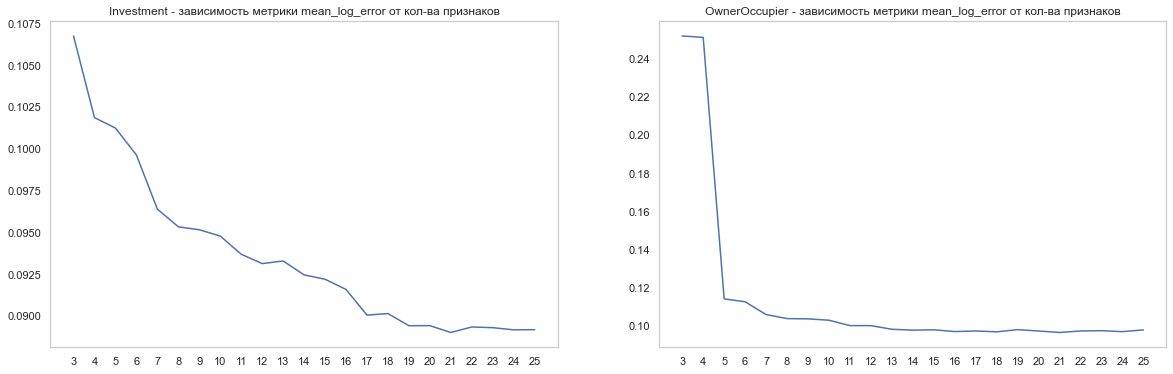

In [46]:
'''
Для первой части модели можно взять 16 самых значимых признаков, для второй части модели 12 самых значимых признаков
'''
fig, ax = plt.subplots(nrows=1,ncols=2)
ax1, ax2 = ax.flatten()

ax1.plot(range(3, 26, 1), Invest_metrics)
ax1.set_title('Investment - зависимость метрики mean_log_error от кол-ва признаков')

ax2.plot(range(3, 26, 1), OwOc_metrics)
ax2.set_title('OwnerOccupier - зависимость метрики mean_log_error от кол-ва признаков')
fig.set_size_inches(20,6)

ax1.set_xticks(np.arange(3, 26, step=1))
ax2.set_xticks(np.arange(3, 26, step=1))

ax1.grid()
ax2.grid()

plt.show()

In [116]:
pd.concat([df_import_Invest,df_import_OwOc],axis=1)

,index,feature_Invest,importance_Invest,index,feature_OwOc,importance_OwOc
0,9,sub_area,364,0,full_sq,377
1,81,ID_metro,225,2,floor,157
2,0,full_sq,187,288,year,151
3,5,build_year,164,289,month,150
4,1,life_sq,133,9,sub_area,113
5,2,floor,107,1,life_sq,99
6,3,max_floor,98,3,max_floor,83
7,288,year,97,6,num_room,81
8,289,month,83,81,ID_metro,56
9,99,ID_railroad_station_avto,77,116,zd_vokzaly_avto_km,48


In [8]:
'''
Список полей, которые будут использоваться в приложении
'''

cols_Invest = [
    'full_sq',
    'floor',
    'month',
    'sub_area',
    'max_floor',
    'life_sq',
    #'num_room',
    'ID_metro', 
    'build_year',
    'year',
    'ID_railroad_station_walk',
    'kitch_sq',
    #'state',
    'metro_min_walk',
    'bulvar_ring_km',
    #'sadovoe_km',
    'mkad_km','ttk_km',
    'product_type','price_sq_m'
              ]

cols_OwOc = ['full_sq',
             'floor',
             'month',
             'sub_area',
             'max_floor',
             'life_sq',
             #'num_room',
             'ID_metro',
             'build_year',
             'year',
             'ID_railroad_station_walk',
             'kitch_sq',
             'metro_min_walk',
             #'kremlin_km',
             'bulvar_ring_km',
             #'sadovoe_km',
             'mkad_km','ttk_km',
             'product_type', 'price_sq_m'
            ]
             
             
        
        
        
        #'bulvar_ring_km',
        #'sadovoe_km',
        #'mkad_km','ttk_km',
        #'kremlin_km',
        #'ID_big_road2',
        #'ID_railroad_station_avto',
        #'ID_railroad_station_walk',
        #'metro_min_walk',
        #'zd_vokzaly_avto_km',
        #'park_km',


In [9]:
train_temp_1 = train

# делим обучающую выборку на две части по полю product_type
train_temp_1_Invest = train_temp_1[train_temp_1.product_type=='Investment'][cols_Invest]
train_temp_1_OwOc = train_temp_1[train_temp_1.product_type=='OwnerOccupier'][cols_OwOc]

# train, test
y_train_1_Invest = train_temp_1_Invest['price_sq_m']
X_train_1_Invest = train_temp_1_Invest.drop(columns = ['price_sq_m','product_type'])
print(f"Investment shape: {X_train_1_Invest.shape},{y_train_1_Invest.shape}")

y_train_1_OwOc = train_temp_1_OwOc['price_sq_m']
X_train_1_OwOc = train_temp_1_OwOc.drop(columns = ['price_sq_m','product_type'])
print(f"OwnerOccupier shape: {X_train_1_OwOc.shape},{y_train_1_OwOc.shape}")


kfold = KFold(n_splits=6, shuffle=True, random_state=42)

score_1 = make_scorer(mean_absolute_error)
score_2 = make_scorer(r2_score)
score_3 = make_scorer(mean_squared_log_error, squared=False)

#Invest: {'learning_rate': 0.026841768402423846, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 545, 
#         'subsample': 0.8697216637775524}
reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     545, 
            learning_rate =    0.026841768402423846, 
            max_depth =        12, 
            min_child_weight = 5, 
            subsample =        0.8697216637775524, 
)


#OwOc: {'learning_rate': 0.029399853388230632, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 432, 
#       'subsample': 0.9716510345987751}
reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     432, 
            learning_rate =    0.029399853388230632, 
            max_depth =        12, 
            min_child_weight = 5, 
            subsample =        0.9716510345987751, 
)


n=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_1)
print(f"\nInvestment mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_Invest,X_train_1_Invest, y_train_1_Invest, cv=kfold,scoring = score_3)
print(f"\nInvestment mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")

n=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_1)
print(f"\nOwnerOccupier mean_absolute: {np.mean(n):.4f}")
print(f"folds mean_absolute: {n}")
n2=cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc, y_train_1_OwOc, cv=kfold,scoring = score_3)
print(f"\nOwnerOccupier mean_log_error: {np.mean(n2):.4f}")
print(f"folds mean_log_error: {n2}")

Investment shape: (13526, 15),(13526,)
OwnerOccupier shape: (9608, 15),(9608,)

Investment mean_absolute: 10.6541
folds mean_absolute: [11.15425574 10.72634483 10.7922231  10.33457911 10.32483397 10.59260214]

Investment mean_log_error: 0.0897
folds mean_log_error: [0.09511112 0.09142156 0.08552483 0.0860145  0.08776704 0.09208028]

OwnerOccupier mean_absolute: 5.2293
folds mean_absolute: [5.42764657 5.06785181 5.29329903 5.17280257 5.30211817 5.11216062]

OwnerOccupier mean_log_error: 0.0723
folds mean_log_error: [0.07688811 0.06724106 0.07363404 0.07232233 0.07290267 0.0706634 ]


In [164]:
Investment shape: (13526, 17),(13526,)
OwnerOccupier shape: (9608, 16),(9608,)

Investment mean_absolute: 10.5407
folds mean_absolute: [10.91932911 10.64404528 10.65127334 10.23413173 10.24610412 10.54939677]

Investment mean_log_error: 0.0889
folds mean_log_error: [0.09352168 0.09158509 0.0844343  0.08573055 0.08710127 0.09125273]

OwnerOccupier mean_absolute: 5.2205
folds mean_absolute: [5.39874685 5.03295324 5.30462363 5.13429811 5.34666269 5.10598071]

OwnerOccupier mean_log_error: 0.0722
folds mean_log_error: [0.07718788 0.06672491 0.0735665  0.07214709 0.07279564 0.07103379]

SyntaxError: invalid syntax (Temp/ipykernel_13192/2097210057.py, line 1)

In [ ]:
# Все признаки
Investment shape: (13526, 291),(13526,)
OwnerOccupier shape: (9608, 291),(9608,)

Investment mean_absolute: 10.5720
folds mean_absolute: [10.87848302 10.64936736 10.8264167  10.18811864 10.33909333 10.55041607]

Investment mean_log_error: 0.0884
folds mean_log_error: [0.09141039 0.09063631 0.08574814 0.08447952 0.08683673 0.09129803]

OwnerOccupier mean_absolute: 5.1556
folds mean_absolute: [5.28730729 4.95245218 5.33255417 5.06723767 5.29906233 4.99489938]

OwnerOccupier mean_log_error: 0.0711
folds mean_log_error: [0.07420776 0.06350716 0.07438847 0.07188379 0.07467987 0.068101  ]

In [10]:
'''
Загрузка модели на диск
'''
reg_lgbm_Invest.fit(X_train_1_Invest, y_train_1_Invest)
reg_lgbm_OwOc.fit(X_train_1_OwOc, y_train_1_OwOc)

filename_Invest = 'finalized_model_Invest.sav'
filename_OwOc = 'finalized_model_OwOc.sav'

joblib.dump(reg_lgbm_Invest, filename_Invest)
joblib.dump(reg_lgbm_OwOc, filename_OwOc)

['finalized_model_OwOc.sav']

In [202]:
'''
Таблица значимости признаков для 1-й части модели
'''

reg_lgbm_Invest.fit(X_train_1_Invest, y_train_1_Invest)
pd.DataFrame({'feature_Invest': reg_lgbm_Invest.feature_name_, 
              'importance_Invest': reg_lgbm_Invest.feature_importances_}).sort_values(by='importance_Invest',ascending=False)

,feature_Invest,importance_Invest
3,sub_area,2373
8,build_year,1748
7,ID_metro,1554
0,full_sq,1463
5,life_sq,1176
1,floor,945
2,month,926
13,metro_min_walk,912
10,ID_railroad_station_walk,872
4,max_floor,832


In [203]:
'''
Таблица значимости признаков для 2-й части модели
'''

reg_lgbm_OwOc.fit(X_train_1_OwOc, y_train_1_OwOc)
pd.DataFrame({'feature_OwOc': reg_lgbm_OwOc.feature_name_, 
              'importance_OwOc': reg_lgbm_OwOc.feature_importances_}).sort_values(by='importance_OwOc',ascending=False)

,feature_OwOc,importance_OwOc
0,full_sq,2129
13,bulvar_ring_km,1106
3,sub_area,1003
14,mkad_km,1002
1,floor,855
12,metro_min_walk,829
5,life_sq,825
4,max_floor,815
2,month,636
9,year,634


In [181]:
X_train_1_Invest_temp = X_train_1_Invest
X_train_1_OwOc_temp = X_train_1_OwOc

In [ ]:
'''
Ниже модель, с которой получился пока лучший результат при загрузке на Kaggle.
Использованы все признаки из первой части модели, а во второй части модели исключены коллинеарные признаки 
с границей 0.8
'''

In [184]:
%%time

'''
Модель для загрузки на Kaggle - подбор параметров для 1-ой части модели.
Это часть, где product_type = Investment (вторичка)

'''
X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns

X_numerical_col_OwOc = X_train_1_OwOc_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_OwOc = X_train_1_OwOc_temp.select_dtypes(exclude = [np.number]).columns


space_lgbm = {  
            'n_estimators':     hp.choice('n_estimators',     np.arange(100, 700, dtype=int)),
            'learning_rate':    hp.uniform('learning_rate',   0.001, 0.03),
            'max_depth':        hp.choice('max_depth',        np.arange(2, 16, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
            'subsample':        hp.uniform('subsample', 0.8, 1),
}


def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_Invest = LGBMRegressor(**space)   #**space
    
    '''
    numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, X_numerical_col_Invest),
            ("cat", categorical_transformer, X_categorial_col_Invest)
            ]
    #, remainder='passthrough'
    
    )

    reg_pipe_Invest = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)])


    '''
    
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_lgbm_Invest, X_train_1_Invest_temp, y_train_1_Invest, cv=kfold,scoring = score))
 
    return {'loss': loss, 'status': STATUS_OK }



trials = Trials()
best = fmin(fn = hyperparameter_tuning,
            #X = X_train_1_Invest,
            #y = y_train_1_Invest,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 30,
            trials = trials)

print ('Invest:',best)
loss = trials.best_trial['result']['loss']
print ('loss Invest:', loss)


100%|███████████████████████████████████████████████| 30/30 [05:48<00:00, 11.60s/trial, best loss: 0.08984123467823953]
Invest: {'learning_rate': 0.026841768402423846, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 545, 'subsample': 0.8697216637775524}
loss Invest: 0.08984123467823953
Wall time: 5min 48s


In [185]:
%%time
'''
Модель для загрузки на Kaggle - подбор параметров для 2-ой части модели.
Это часть, где product_type = OwnerOccupier (первичка)

Проблема, которую не смог решить - не смог провести категориальные фичи через pipeline и columntransformer
с помощью remainder='passthrough' без применения onehotencoder и пр., чтобы lgbm принял их. 
Возникает ошибка - ValueError: could not convert string to float

'''

def hyperparameter_tuning(space):  #space, 
    # Инициализируем регрессор
    reg_lgbm_OwOc = LGBMRegressor(**space)   #**space

       
    kfold = KFold(n_splits=6, shuffle=True, random_state=42)
    score = make_scorer(mean_squared_log_error, squared=False)
    loss = np.mean(cross_val_score(reg_lgbm_OwOc, X_train_1_OwOc_temp, y_train_1_OwOc, cv=kfold,scoring = score))
 
    return {'loss': loss, 'status': STATUS_OK }




trials = Trials()

best = fmin(fn = hyperparameter_tuning,
            space = space_lgbm,
            algo = tpe.suggest,
            max_evals = 30,
            trials = trials)

print ('OwOc:', best)
loss = trials.best_trial['result']['loss']
print ('loss OwOc:', loss)

100%|███████████████████████████████████████████████| 30/30 [03:11<00:00,  6.39s/trial, best loss: 0.07187121571940158]
OwOc: {'learning_rate': 0.029399853388230632, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 432, 'subsample': 0.9716510345987751}
loss OwOc: 0.07187121571940158
Wall time: 3min 11s


In [429]:
X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns
X_categorial_col_Invest

Index(['material', 'state', 'sub_area', 'ID_metro', 'ID_railroad_station_walk',
       'ID_railroad_station_avto', 'ID_big_road1', 'ID_big_road2',
       'ID_railroad_terminal', 'ID_bus_terminal', 'ecology', 'year', 'month',
       'dow'],
      dtype='object')

In [433]:
'''
Модель для загрузки на Kaggle
Обучение и предсказание после отбрасывания колинеарных признаков:
оставлены все признаки  на 1-ой части, на второй части использован treshold 0.8

Что интересно, результат после загрузки на Kaggle  получился заметно лучше:
Private score: 0.32078
Public score: 0.32218
'''
#'''

X_numerical_col_Invest = X_train_1_Invest_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_Invest = X_train_1_Invest_temp.select_dtypes(exclude = [np.number]).columns

X_numerical_col_OwOc = X_train_1_OwOc_temp.select_dtypes(include = [np.number]).columns
X_categorial_col_OwOc = X_train_1_OwOc_temp.select_dtypes(exclude = [np.number]).columns

Inv_col = X_train_1_Invest_temp.columns
X_test_Invest_temp = X_test_Invest[Inv_col]

OwOc_col = X_train_1_OwOc_temp.columns
X_test_OwOc_temp = X_test_OwOc[OwOc_col]

#Invest: {'learning_rate': 0.015046104433395484, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 501, 
#'subsample': 0.850903786801252}
#Invest: {'learning_rate': 0.019202327930907613, 'max_depth': 13, 'min_child_weight': 4, 'n_estimators': 431, 
#'subsample': 0.8530417840957498}
#loss Invest: 0.42073079927323404

reg_lgbm_Invest = LGBMRegressor(
            n_estimators =     431, 
            learning_rate =    0.019202327930907613, 
            max_depth =        13, 
            min_child_weight = 4, 
            subsample =        0.8530417840957498, 
           
)




numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_col_Invest),
        ("cat", categorical_transformer, X_categorial_col_Invest)
        ]
    #, remainder='passthrough'
    
    )

reg_pipe_Invest = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_Invest)])




reg_pipe_Invest.fit(X_train_1_Invest_temp, y_train_1_Invest)
y_pred_Invest = reg_pipe_Invest.predict(X_test_Invest_temp)




#OwOc: {'learning_rate': 0.02784644354057584, 'max_depth': 8, 'min_child_weight': 1, 
#       'n_estimators': 592, 'subsample': 0.9016631125458168}

#OwOc: {'learning_rate': 0.02734739405873579, 'max_depth': 11, 'min_child_weight': 6, 
#'n_estimators': 570, 'subsample': 0.8426057635708013}     loss OwOc: 0.10503555148802013

reg_lgbm_OwOc = LGBMRegressor(
            n_estimators =     592, 
            learning_rate =    0.02784644354057584, 
            max_depth =        8, 
            min_child_weight = 1, 
            subsample =        0.9016631125458168, 
)

'''
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")), 
           ("scaler", StandardScaler())] #MinMaxScaler()
    )

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numerical_col_OwOc),
        ("cat", categorical_transformer, X_categorial_col_OwOc)
        ]
    #, remainder='passthrough'
    
    )

reg_pipe_OwOc = Pipeline(steps=[("preprocessor", preprocessor), ("regression", reg_lgbm_OwOc)])

'''

reg_lgbm_OwOc.fit(X_train_1_OwOc_temp, y_train_1_OwOc)
y_pred_OwOc = reg_lgbm_OwOc.predict(X_test_OwOc_temp)

#'''
y_pred_Invest = pd.Series(y_pred_Invest,name='price_sq_m')
Y_test_Invest = pd.concat([X_test_Invest_temp.full_sq.reset_index(),test_Invest_id.reset_index(), y_pred_Invest], axis=1)

y_pred_OwOc = pd.Series(y_pred_OwOc,name='price_sq_m')
Y_test_OwOc = pd.concat([X_test_OwOc_temp.full_sq.reset_index(),test_OwOc_id.reset_index(), y_pred_OwOc], axis=1)

Y_test = pd.concat([Y_test_Invest,Y_test_OwOc], axis=0).sort_values('id')
Y_test['price_doc'] = (Y_test.full_sq * Y_test.price_sq_m * 1000).round(2)
Y_test = Y_test.drop(columns = ['index', 'full_sq', 'price_sq_m'])
Y_test.set_index(['id']).to_csv('Y_test.csv', sep = ',')
#'''